In [1]:
import os
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import torch
import pandas as pd
import torchvision
from tqdm.notebook import tqdm
import pytorch_lightning as pl
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision.transforms import Normalize
from torchmetrics.classification import MulticlassConfusionMatrix, F1Score, MulticlassPrecision, MulticlassRecall
import torchsummary
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from pytorch_lightning.callbacks import Callback
import torch.nn as nn
from tempfile import TemporaryDirectory
from datetime import datetime
import time 

matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
sns.reset_orig()
sns.set()


# PyTorch TensorBoard support

# Tensorboard extension (for visualization purposes later)
%load_ext tensorboard
# Setting the seed
pl.seed_everything(42)
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Seed set to 42


Device: cuda:0


## Notes: 
### - `ELM <=> H-mode`: All ELMs are now labeled as H-modes.


## Create a training dataset

In [2]:
path = Path(os.getcwd())


In [341]:
shots = [16534, 16769, 16773, 18130, 19237, 19240, 19379, 18057, 16989]
shots_for_testing = [16769, 18130, 18057]
shots_for_validation = [19237]

shot_df = pd.DataFrame([])

for shot in shots:
    df = pd.read_csv(f'{path}/data/LHmode-detection-shots/LHmode-detection-shot{shot}.csv')
    df['shot'] = shot
    shot_df = pd.concat([shot_df, df], axis=0)


df_mode = shot_df['mode'].copy()
df_mode[shot_df['mode']=='L-mode'] = 0
df_mode[shot_df['mode']=='H-mode'] = 1
df_mode[shot_df['mode']=='ELM'] = 0 
shot_df['mode'] = df_mode
shot_df = shot_df.reset_index(drop=True) #each shot has its own indexing

########################  Images from RIS2 camera  ######################## 
# ris2_names = shot_df['filename'].str.replace('RIS1', 'RIS2')
# shot_df_RIS2 = shot_df.copy()
# shot_df_RIS2['filename'] = ris2_names

######################## Combine both datasets  ##############################
#shot_df = pd.concat([shot_df, shot_df_RIS2], axis=0)
#shot_df = shot_df.reset_index(drop=True) #each shot has its own indexing

# Precalculated mean and std for each color FROM  https://github.com/pytorch/examples/blob/97304e232807082c2e7b54c597615dc0ad8f6173/imagenet/main.py#L197-L198
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


class ImageDataset(Dataset):
    def __init__(self, annotations, img_dir, mean, std):
        self.img_labels = annotations #pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.loc[idx, 'filename'])
        image = read_image(img_path).float()
        normalized_image = (image - self.mean[:, None, None])/(255 * self.std[:, None, None])
        label = self.img_labels.iloc[idx]['mode']
        time = self.img_labels.iloc[idx]['time']
        return normalized_image, label, img_path, time
        

Vast majority of original dataset are L-modes. Here I'm balancing the data so that `len(l_modes)==len(hmodes_and_elms)`

In [4]:
print(f"There is {len(shot_df[shot_df['mode']==0])/len(shot_df)*100}% of L-modes")
print(f"There is {len(shot_df[shot_df['mode']==1])/len(shot_df)*100}% of H-modes")
print(f"There is {len(shot_df[shot_df['mode']==2])/len(shot_df)*100}% of ELMS")

There is 85.96787335583751% of L-modes
There is 14.032126644162496% of H-modes
There is 0.0% of ELMS


### Old balancing

In [5]:
# hmodes_and_elms = shot_df[shot_df['mode']!=0]
# l_modes = shot_df[shot_df['mode']==0].sample(len(hmodes_and_elms))
# shot_df = pd.concat([hmodes_and_elms, l_modes], axis=0)
# shot_df = shot_df.reset_index(drop=True)

## Balancing

In [6]:
#First split the dataset
test_df = shot_df[shot_df['shot'].isin(shots_for_testing)].reset_index(drop=True)
val_df = shot_df[shot_df['shot'].isin(shots_for_validation)].reset_index(drop=True)
train_df = shot_df[(~shot_df['shot'].isin(shots_for_validation))&(~shot_df['shot'].isin(shots_for_testing))].reset_index(drop=True)

#Then calculate weights
def get_dset(df, path, batch_size):
    mode_weight = (1/df['mode'].value_counts()).values
    sampler_weights = df['mode'].map(lambda x: mode_weight[x]).values
    sampler = WeightedRandomSampler(sampler_weights, len(df), replacement=True)
    dataset = ImageDataset(annotations=df, img_dir=path, mean=mean, std=std)
    dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    return dataloader

batch_size = 32

train_dataloader = get_dset(train_df, path=path, batch_size=batch_size)
test_dataloader = get_dset(test_df, path=path, batch_size=batch_size)
val_dataloader = get_dset(val_df, path=path, batch_size=batch_size)

Dataset itself

## Check if data is balanced

In [7]:
print('Counts in train dataloader:', next(iter(train_dataloader))[1].unique(return_counts=True)[1])
print('Counts in test dataloader:', next(iter(test_dataloader))[1].unique(return_counts=True)[1])
print('Counts in val dataloader:', next(iter(val_dataloader))[1].unique(return_counts=True)[1])


Counts in train dataloader: tensor([17, 15])
Counts in test dataloader: tensor([14, 18])
Counts in val dataloader: tensor([17, 15])


In [8]:
dataloaders = {'train':train_dataloader, 'val':val_dataloader}
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

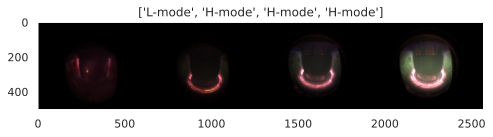

In [9]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(inp)
    ax.grid(False)
    if title is not None:
        plt.title(title)


modes = ['L-mode', 'H-mode', 'ELM']


example_batch = next(iter(test_dataloader))
example_inputs, example_classes,  _, __ = example_batch #we don't need img paths nor time

#Denormalize inputs. Dividing the mean by 255 is conditioned by, that normalization is made on pictures with (0.:1.) values. Look for normalized image in ImageDataset() 
denormalized_inputs = example_inputs * std[:, None, None] + mean[:, None, None]/255

# Make a grid from batch
wide_image = torchvision.utils.make_grid(denormalized_inputs[:4])
imshow(wide_image, title=[modes[x] for x in example_classes[:4]])

## Playing with TensorBoard

In [10]:
timestamp =  datetime.fromtimestamp(time.time()).strftime("%d-%m-%Y, %H-%M-%S ") + input('add comment: ')

# create grid of images
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/{timestamp}')

# write to tensorboard
writer.add_image(f'run {timestamp} four_compass images', wide_image)
writer.close()

## Import ResNet pretrained model


In [230]:
pretrained_model = torchvision.models.resnet18(weights='IMAGENET1K_V1', )
num_ftrs = pretrained_model.fc.in_features
# Here the size of each output sample is set to 3.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(modes))``.
pretrained_model.fc = torch.nn.Linear(num_ftrs, 3) #3 classes: L-mode, H-mode, ELM


### Freeze all the weights excepts those of last fc layer

In [231]:
for param in pretrained_model.parameters():
    param.requires_grad = False
 
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 3) #3 classes: L-mode, H-mode, ELM

In [13]:
pretrained_model = pretrained_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=0.001) #pouzit adam

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [14]:
#adding graph of the model to tensorboard
writer.add_graph(pretrained_model, example_inputs.float().to(device))
writer.close()

### Tracking model training with TensorBoard

In [15]:
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    with torch.no_grad():
        output = net(images)
    # convert output probabilities to predicted class
    max_logit, class_prediction = torch.max(output, 1) 
    preds = np.squeeze(class_prediction.cpu().numpy())
    return output, preds, [torch.nn.functional.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, img_paths, labels, identificator):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along   
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    timestamp = datetime.fromtimestamp(time.time()).strftime("%d-%m-%Y, %H-%M-%S")
    _, preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(16,9))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        image = read_image(img_paths[idx]).numpy()
        plt.grid(False)
        plt.imshow(np.transpose(image, (1, 2, 0)))
        ax.set_title("Prediction: {0}, {1:.1f}%\n(Label: {2})".format(
            modes[preds[idx]],
            probs[idx] * 100.0,
            modes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    plt.savefig(f'{path}/preds_vs_actuals/preds_vs_actuals_{timestamp}_{identificator}.jpg')
    return fig



## Training
### Original training function was copied from [tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#finetuning-the-convnet) and modified in order to integrate tensorboard

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, comment = ''):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                num_of_samples = 0
                running_batch = 0
                # Iterate over data.
                #TODO: eliminate the need in that dummy iterative for tensorboard part
                for inputs, labels, img_paths, time in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device).float() # #TODO: is it smart to convert double to float here? 
                    labels = labels.to(device)
                    
                    running_batch += 1
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs) #2D tensor with shape Batchsize*len(modes)
                        #TODO: inputs.type. 
                        _, preds = torch.max(outputs, 1) #preds = 1D array of indicies of maximum values in row. ([2,1,2,1,2]) - third feature is largest in first sample, second in second...
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    num_of_samples += inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data) #How many correct answers
                    
                    
                    #tensorboard part
                    
                    if running_batch % int(len(dataloaders[phase])/10)==int(len(dataloaders[phase])/10)-1: 
                        # ...log the running loss
                        
                        #Training/validation loss
                        writer.add_scalar(f'{phase}ing loss {comment}',
                                        running_loss / num_of_samples,
                                        epoch * len(dataloaders[phase]) + running_batch)
                        
                        #F1 metric
                        writer.add_scalar(f'{phase}ing F1 metric {comment}',
                                        F1Score(task="multiclass", num_classes=3).to(device)(preds, labels),
                                        epoch * len(dataloaders[phase]) + running_batch)
                        
                        #Precision recall
                        writer.add_scalar(f'{phase}ing macro Precision {comment}', MulticlassPrecision(num_classes=3).to(device)(preds, labels),
                                          epoch * len(dataloaders[phase]) + running_batch)
                        
                        writer.add_scalar(f'{phase}ing macro Recall {comment}', MulticlassRecall(num_classes=3).to(device)(preds, labels),
                                          epoch * len(dataloaders[phase]) + running_batch)
                        
                        
                    
                    if running_batch % int(len(dataloaders[phase])/3)==int(len(dataloaders[phase])/3)-1:
                        # ...log a Matplotlib Figure showing the model's predictions on a
                        # random mini-batch
                        writer.add_figure(f'predictions vs. actuals {comment}',
                                        plot_classes_preds(model, inputs, img_paths, labels, identificator=phase),
                                        global_step=epoch * len(dataloaders[phase]) + running_batch)
                        writer.close()
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    writer.add_scalar(f'best_accuracy for epoch {comment}',
                                        epoch_acc,
                                        epoch)
                    writer.close()
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

## Train last .fc layer

In [17]:

model = train_model(pretrained_model, criterion, optimizer,
                                 exp_lr_scheduler, num_epochs=2, comment='Last f.c.')

model_path = Path(f'{path}/runs/{timestamp}/model_fc_trained.pt')
torch.save(model.state_dict(), model_path)

Epoch 1/2
----------


  0%|          | 0/280 [00:00<?, ?it/s]

train Loss: 0.2695 Acc: 0.9215


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.1451 Acc: 0.9662

Epoch 2/2
----------


  0%|          | 0/280 [00:00<?, ?it/s]

train Loss: 0.1288 Acc: 0.9689


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.1117 Acc: 0.9734

Training complete in 5m 23s
Best val Acc: 0.973361


## Testing

Model predicted that is a H-mode with 57.1% confidence


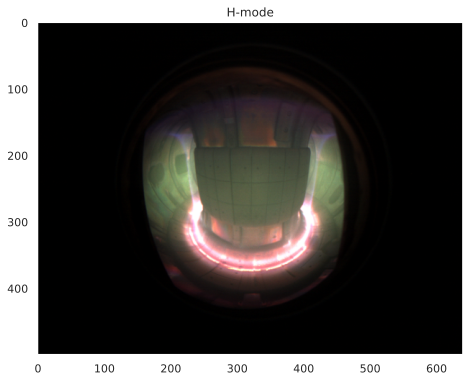

In [18]:
random_index = np.random.randint(0,batch_size-1)
_, predictions, confidences = images_to_probs(model,example_inputs.float().to(device))

pred, con = predictions[random_index], confidences[random_index]

imshow(denormalized_inputs[random_index], title=modes[example_classes[random_index]])
print(f"Model predicted that is a {modes[pred]} with {con*100:3.1f}% confidence") 

In [19]:


def test_model(model, test_dataloader):
    y_df = torch.tensor([])
    y_hat_df = torch.tensor([])
    preds = pd.DataFrame(columns=['Prediction', 'label'])

    for batch_index, (img, y, paths) in enumerate(test_dataloader):
        _, y_hat, confidence = images_to_probs(model,img.float().to(device))
        y_hat = torch.tensor(y_hat)
        y_df = torch.cat((y_df, y), dim=0)
        y_hat_df = torch.cat((y_hat_df, y_hat), dim=0)

        pred = pd.DataFrame({'Prediction': y_hat.data, 'label': y.data})

        preds = pd.concat([preds, pred],axis=0, ignore_index=True)

        if batch_index>50:
            break

    #Confusion matrix
    confusion_matrix_metric = MulticlassConfusionMatrix(num_classes=3)
    confusion_matrix_metric.update(y_hat_df, y_df)
    fig_confusion_matrix, ax_ = confusion_matrix_metric.plot()

    #F1
    f1 = F1Score(task="multiclass", num_classes=3)(y_hat_df, y_df)

    #Precision
    precision = MulticlassPrecision(num_classes=3)(y_hat_df, y_df)
    recall = MulticlassRecall(num_classes=3)(y_hat_df, y_df)
    #precision(logits_df, y_df.int())

    #Accuracy
    accuracy = len(preds[preds['Prediction']==preds['label']])/len(preds)
    return fig_confusion_matrix, preds, f1, precision, recall, accuracy

confusion_matrix_fr, predictions_fr, f1_fr, precision_fr, recall_fr, accuracy_fr = test_model(model, test_dataloader)

writer.add_figure(f'Confusion matrix for the model with trained f.c. layer', confusion_matrix_fr)
writer.add_scalar(f'Accuracy on test_dataset with trained f.c. layer', accuracy_fr)
writer.add_scalar(f'F1 metric on test_dataset with trained f.c. layer', f1_fr)
writer.add_scalar(f'Precision on test_dataset with trained f.c. layer', precision_fr)
writer.add_scalar(f'Recall on test_dataset with trained f.c. layer', recall_fr)
writer.close()

## Unfreeze all layers and complete the training

In [20]:
for param in model.parameters():
    param.requires_grad = True

model = train_model(model, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=2, comment='All layers')

Epoch 1/2
----------


  0%|          | 0/280 [00:00<?, ?it/s]

train Loss: 0.1038 Acc: 0.9752


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.0850 Acc: 0.9764

Epoch 2/2
----------


  0%|          | 0/280 [00:00<?, ?it/s]

train Loss: 0.0537 Acc: 0.9841


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.1343 Acc: 0.9693

Training complete in 7m 2s
Best val Acc: 0.976434


In [21]:
model_path = Path(f'{path}/runs/{timestamp}/model_fully_trained.pt')
torch.save(model.state_dict(), model_path)

## Testing fully trained model

In [22]:
confusion_matrix_fr, predictions_fr, f1_fr, precision_fr, recall_fr, accuracy_fr = test_model(model, test_dataloader)

writer.add_figure(f'Confusion matrix for the model with all layers unfrozen', confusion_matrix_fr)
writer.add_scalar(f'Accuracy on test_dataset with all layers unfrozen', accuracy_fr)
writer.add_scalar(f'F1 metric on test_dataset with all layers unfrozen', f1_fr)
writer.add_scalar(f'Precision on test_dataset with all layers unfrozen', precision_fr)
writer.add_scalar(f'Recall on test_dataset with all layers unfrozen', recall_fr)
writer.close()

In [339]:
type(model)

torchvision.models.resnet.ResNet

In [325]:
def post_process_testing_model(model, test_dataloader):
    preds = pd.DataFrame(columns=['Prediction', 'label', 'time', 'confidence'])

    for batch_index, (img, y, paths,  times) in enumerate(test_dataloader):
        logits, y_hat, confidence = images_to_probs(model,img.float().to(device))
        y_hat = torch.tensor(y_hat)
        confidence = torch.tensor(confidence)

        pred = pd.DataFrame({'Prediction': y_hat.data, 'label': y.data, 'time':times, 'confidence':confidence.data})

        preds = pd.concat([preds, pred],axis=0, ignore_index=True)
        if batch_index>680:
            break
    return preds

In [336]:
test_shot = 16773#[16769, 18130, 18057]
testing_df = shot_df[shot_df['shot']==test_shot].reset_index(drop=True)
test_dataset_after = ImageDataset(annotations=testing_df, img_dir=path, mean=mean, std=std)
test_dataloader_after = DataLoader(test_dataset_after, batch_size=3, shuffle=False)

In [337]:
predsss = post_process_testing_model(model, test_dataloader_after)
predsss.to_csv(f'{path}/runs/{timestamp}/time_line_for_shot_{test_shot}.csv')

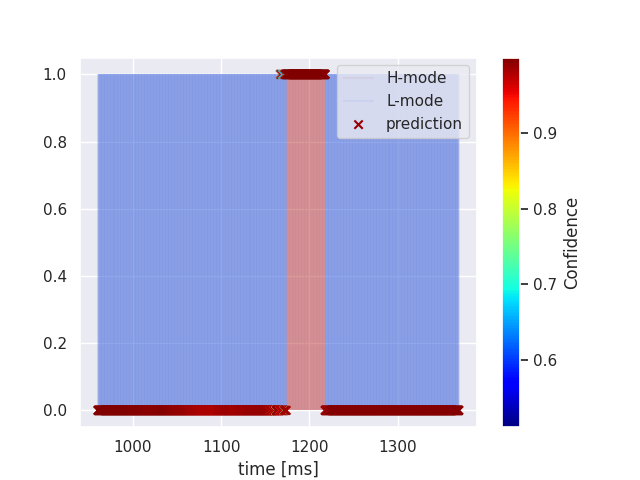

In [338]:
%matplotlib widget

fig, ax = plt.subplots()
ax.vlines(predsss['time'][predsss['label']==1], 0, 1, lw=0.1, color='r', zorder=1, label='H-mode')
ax.vlines(predsss['time'][predsss['label']==0], 0, 1, lw=0.1, color='royalblue', zorder=1, label='L-mode')
pred_points = ax.scatter(predsss['time'], predsss['Prediction'], c=predsss['confidence'], label='prediction', cmap='jet', marker='x', zorder=10)
ax.set_xlabel('time [ms]')
ax.legend(loc='best')
fig.colorbar(pred_points, label='Confidence')
fig.set_label(f'shot {test_shot}')